# ¿Que más se podría hacer?

En negrita se resaltan las propuestas a desarrollar:

- **Test con data augmentation y la LSTM**
- Usar los tokenizadores usados en los transformers para ver como funcionan
- **TSNE de embeddings y analizar si hay interpretación**
- Probar con otras encimas o proteinas
- Usar los embeddings entrenados para analizar resultados de proteinas o encimas con menos data
- Entrenar una red neuronal con los features (fingerprints por ejemplo) y comparar los resultados con los embeddings


# Tome cualquiera de estas propuestas o alguna suya y desarrolle

### Configuración para Colab

In [83]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
PROJECT_PATH = "/content/drive/MyDrive/final_nlp/"
! cp {PROJECT_PATH}"datagen.py" ./
! cp {PROJECT_PATH}"dataaug.py" ./

In [3]:
! pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports Generales

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Embedding, Bidirectional, Activation, Input, Conv1D, MaxPool1D, Concatenate, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from datagen import smiles_dict, smiles_to_seq, DataGenerator

## Test con data augmentation & LSTM

Reentreno la LSTM de la notebook 003 con la misma técnica de Data Augmentation implementada en la notebook 004.

In [5]:
df = pd.read_csv(PROJECT_PATH + 'data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20
X = df['canonical_smiles'].values
y = df['pIC50'].values
vocab_size = len(smiles_dict)

In [6]:
print(vocab_size)
print(max_sequence_len)

42
227


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

### Modelo LSTM

In [9]:
# Métrica
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [73]:
# Defino funciones para crear modelos y probar con distintos hiperparámetros más rápido.
def create_model(cells, emb_size):
  return_sequences = False
  model = Sequential()
  model.add(Embedding(vocab_size+1, emb_size, input_length=max_sequence_len))
  model.add(Bidirectional(LSTM(cells, return_state=False, return_sequences=return_sequences, activation='tanh')))
  model.add(Dense(512, activation='linear'))
  # model.add(BatchNormalization())
#  model.add(Dropout(0.8))
  model.add(Dense(512, activation='linear'))
  # model.add(BatchNormalization())
#  model.add(Dropout(0.8))
  model.add(Dense(512, activation='linear'))
  # model.add(BatchNormalization())
  model.add(Dense(1, activation='linear'))
  return model

In [74]:
def get_callbacks():

  early_stopping = EarlyStopping(
      monitor = 'val_loss',
      min_delta = 0.01,
      patience = 15,
      verbose = 1,
      restore_best_weights = True
  )

  reduce_lr = ReduceLROnPlateau(
      monitor = 'val_loss',
      factor = 0.1,
      patience = 10,
      verbose = 1,
      min_delta = 0.01,
      cooldown = 0,
      min_lr = 1e-8

  )

  checkpoint = ModelCheckpoint(
      filepath = PROJECT_PATH + 'models/cnn/best_model_{epoch}', 
      monitor = 'val_R2',
      verbose = True,
      mode = 'max',
      save_best_only = True,
      save_format = 'h5'
  )

  return (early_stopping, reduce_lr)

In [75]:
def score_model(model):
  X_test_eval = []
  y_t_eval = []
  for X_t, y_t in dgen_test:
      X_test_eval = X_test_eval + [list(t) for t in X_t]
      y_t_eval = y_t_eval + list(y_t)
  X_test_eval = np.array(X_test_eval)
  y_test = np.array(y_t_eval)
  y_pred = model.predict(X_test_eval)
  r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
  return r2

def save_model(model, path):
  model.save(path)

def try_model(nombre, params):
    
    model = create_model(*params)
    
    print(model.summary())
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[R2])
    history = model.fit(dgen_train, epochs=100, validation_data = dgen_test, callbacks=callbacks)

    r2 = score_model(model)
    print(f"\n R2 val:{r2}")
    
    model.save('./models/lstm_aug/' + nombre + '.h5')

    return model

In [76]:
cells = 100
emb_size = 64
params = (cells, emb_size)

In [77]:
callbacks = get_callbacks()

In [78]:
nombre = 'emb64-bi_lstm_100-dense_512_linx3-dense_1'
_ = try_model(nombre, params)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 227, 64)           2752      
                                                                 
 bidirectional_10 (Bidirecti  (None, 200)              132000    
 onal)                                                           
                                                                 
 dense_35 (Dense)            (None, 512)               102912    
                                                                 
 dense_36 (Dense)            (None, 512)               262656    
                                                                 
 dense_37 (Dense)            (None, 512)               262656    
                                                                 
 dense_38 (Dense)            (None, 1)                 513       
                                                     

### Resumen
- Embx64>Bidir LSTM x 100 cells>Dense 50 (linear)>BatchNorm > Dense 1 = 0.339
- Embx64 > Bidir LSTM x 100 cells>[Dense 512 (linear)>BatchNorm>Dropout80]x2>Dense 1 = 0.166
- Embx64 > Bidir LSTM x 100 cells>Dense 512 relu>Dense 512 lin>Dense 1 = 0.318
- Embx128 > Bidir LSTM x 100 cells>Dense 1024 relu>Dense 512 lin x 2>Dense 1 = 0.318
- Embx64 > Bidir LSTM x 100 cells>Dense 512 lin x 3>Dense 1 = 0.472

Se esperaba que con este método de tokenización y data augmentation, se consiguieran mejores puntajes de R2 respecto del modelo LSTM entrenado anteriormente (NB 003).

Quizás podría mejorarse buscando otras arquitecturas y configuraciones de capas densas a las salida del modelo

## TSNE de embeddings

In [37]:
tsne = TSNE(2)

In [88]:
# Cargo los mejores modelos de cada arquitectura
model_lstm_path = 'models/lstm_aug/emb64-bi_lstm_100-dense_512_linx3-dense_1.h5'
model_cnn_path = PROJECT_PATH + 'models/cnn/A_emb128_3xtextcnn_conc_flat_2x256-relu-BN.h5'

model_lstm = load_model(model_lstm_path, custom_objects={'R2': R2})
model_cnn = load_model(model_cnn_path, custom_objects={'R2': R2})

# Al LSTM también lo entrené en esta notebook con el vocabulario de smiles_dict, y creo que es mejor comparar ambos modelos con este vocabulario

# d1 = {'c': 1, 'C': 2, '(': 3, ')': 4, '1': 5, 'O': 6, '2': 7, 'N': 8, '=': 9, '3': 10, '[': 11, ']': 12, '@': 13, 'n': 14, '4': 15,'H': 16, 
#      '-': 17, '/': 18, 'l': 19, '.': 20, '+': 21, 'F': 22, '5': 23, 'o': 24, 'B': 25, 'r': 26, 'S': 27, '\\': 28, '#': 29, '6': 30, 's': 31, 
#       'I': 32, 'e': 33, 'P': 34, '7': 35, '8': 36, 'i': 37, 'a': 38}

d1 = d2 = smiles_dict

models = [model_lstm, model_cnn]
dicts = [d1, d2]
titles = ['LSTM', 'CNN']

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


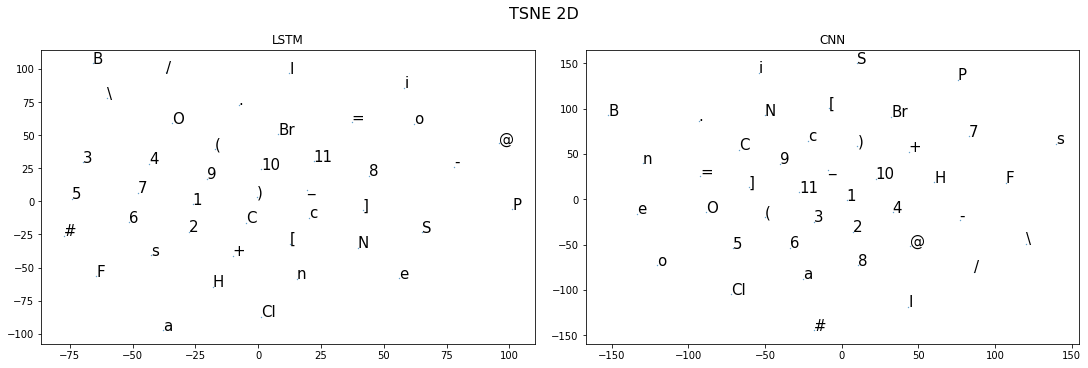

In [90]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5))
fig.suptitle('TSNE 2D', fontsize=16)
j = 0
for model, d, title in zip(models, dicts, titles):
    embedings = model.layers[j].get_weights()[0][1:]
    X_2 = tsne.fit_transform(embedings)
    axs[j].scatter(X_2[:, 0], X_2[:, 1], s=0.1)
    for i, token in enumerate(d):
        axs[j].text(X_2[i, 0], X_2[i, 1], token, fontsize=15)
    
    axs[j].set_title(title)
    j+=1

plt.show()

El agrupamiento generado por los embeddings de cada modelo es distinto,  sin embargo se aprecia que:
- Los valores numéricos tienden a agruparse en ambos modelos
- En ambos modelos los caracteres B y P se encuentran alejados del resto.